In [1]:
import os, random, matplotlib, pickle, yaml, hdbscan
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

In [2]:
result_path = "../results/round2"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])

In [44]:
config_path = ".."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
root_path = ".."
bp, marker_embed, limb_embed, angle_embed, all_embed = [], [], [], [], []
for file in tqdm(INFO_values):
    bp.append( np.load(f"{root_path}/{file['directory']}/rotated_bodypoints.npy") )
    marker_embed.append( np.load(f"{root_path}/{file['directory']}/marker_postural_embeddings.npy") )
    limb_embed.append( np.load(f"{root_path}/{file['directory']}/limb_postural_embeddings.npy") )
    angle_embed.append( np.load(f"{root_path}/{file['directory']}/angle_postural_embeddings.npy") )
    all_embed.append( np.load(f"{root_path}/{file['directory']}/all_postural_embeddings.npy") )

bp = np.concatenate(bp)
marker_embed = np.concatenate(marker_embed)
limb_embed = np.concatenate(limb_embed)
angle_embed = np.concatenate(angle_embed)
all_embed = np.concatenate(all_embed)

In [43]:
test1 = np.ones((10000,45))
test2 = np.ones((10000,42))
test3 = np.ones((10000,12))

np.concatenate([
    test1,test2,test3
], axis=1).shape

(10000, 99)

In [4]:
skeleton = [
    [0,1,2,3],
    [4,5,6,7],
    [8,9,10],
    [11,12,13],
    [14,15,16],
    [17,18,19,20],
    [21,22,23],
    [24,25,26],
    [27,28,29]
]
skeleton_color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan']

In [5]:
# global variables
(num_fr, num_components) = all_embed.shape

In [6]:
def HDBSCAN(embed, min_cluster_size=7000, min_samples=10, cluster_selection_epsilon=0, cluster_selection_method="leaf", memory="memory"):
    # HDBSCAN
    (good_fr, good_bp) = np.where( ~np.isnan(embed) )
    good_fr = np.unique(good_fr)
    labels = np.ones(num_fr)*-2

    # hdbscan clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                min_samples=min_samples,
                                cluster_selection_epsilon=cluster_selection_epsilon,
                                cluster_selection_method=cluster_selection_method,
                                memory=memory
                               ).fit(embed[good_fr,:])
    # parameters
    labels[good_fr] = clusterer.labels_
    num_clusters = int(np.max(labels)+1)
    outlier_pts = np.where(labels== -1)[0]
    print(f"Frac Outlier: {len(outlier_pts)/len(labels)}")
    print(f"# Clusters: {num_clusters}")
    
    return labels, num_clusters

def plot_HDBSCAN(ax, embed, labels, color_palette, xlim=None, ylim=None):
    num_clusters = int(np.max(labels)+1)
    outlier_pts = np.where(labels== -1)[0]
    labeled_pts = np.where(labels!= -1)[0]

    # cmap: coloring
    
    cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                      else (0.5, 0.5, 0.5)
                      for x in labels])

    # cluster colors
    ax.scatter(embed[outlier_pts,0], embed[outlier_pts,1], 
               c="gray", s=1, alpha=0.01)
    ax.scatter(embed[labeled_pts,0], embed[labeled_pts,1], 
               c=cluster_colors[labeled_pts], s=1, alpha=0.2)
    ax.set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features HDBSCAN Clusters")
    
    # numbering
    cluster_mean = []
    for i in tqdm(range(num_clusters)):
        idx = (labels==i)
        ax.annotate(i, np.mean(embed[idx,:], axis=0), fontsize=14, fontweight='bold')
        cluster_mean.append(np.mean(embed[idx,:], axis=0).tolist())
    cluster_mean = np.array(cluster_mean)
    
    if (xlim!=None) | (ylim!=None):
        ax.set(xlim=xlim, ylim=ylim)

<center><h1>All Embedding </h1></center>

In [8]:
# hdbscan
labels, num_clusters = HDBSCAN(all_embed, min_cluster_size=5000, min_samples=10, 
                               cluster_selection_epsilon=0, cluster_selection_method="leaf", 
                               memory="memory")
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette)

Frac Outlier: 0.5771982081993963
# Clusters: 21


In [13]:
%matplotlib qt 
# %matplotlib inline

idx = random.choices(np.arange(num_fr), k=int(num_fr*2/3))

# Scatter Plot
fig_all_embed, ax_all_embed = plt.subplots(1,3,figsize=(30,6), sharex=True, sharey=True)

ax_all_embed[0].scatter(all_embed[idx,0], all_embed[idx,1], s=1, alpha=0.015)
ax_all_embed[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding")

# Density Plot
sns.kdeplot(x=all_embed[idx,0], y=all_embed[idx,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.3,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_all_embed[1])
ax_all_embed[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                    xlim=ax_all_embed[0].get_xlim() ,ylim=ax_all_embed[0].get_ylim())

# Cluster Plot
plot_HDBSCAN(ax_all_embed[2], all_embed, labels, color_palette)

plt.show()

In [122]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed[0].get_xlim())[0]
ax_y_length = np.diff(ax_all_embed[0].get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

## Region 1: Center

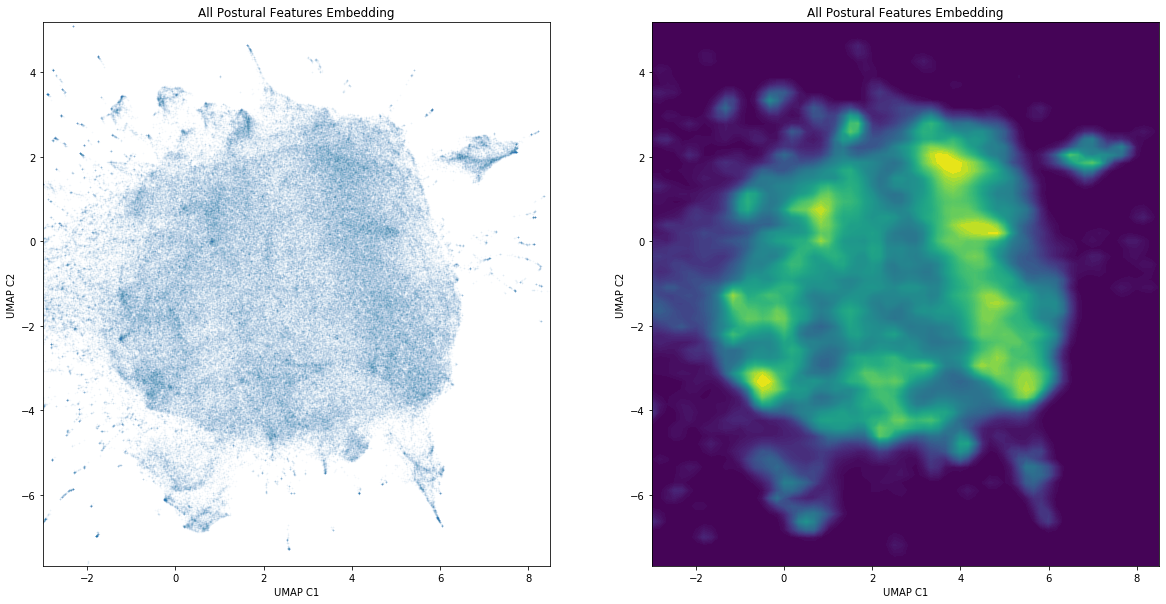

In [130]:
### Region 1

# find figure bounds
region_x_lim, region_y_lim = (-4,8.5), (-6.5,3)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

# plot region 1
plot_embedding(all_embed, region_x_lim, region_y_lim, frac_pts=1/2, 
               scatter_s=1, scatter_alpha=0.025, 
               kde_gridsize=300)

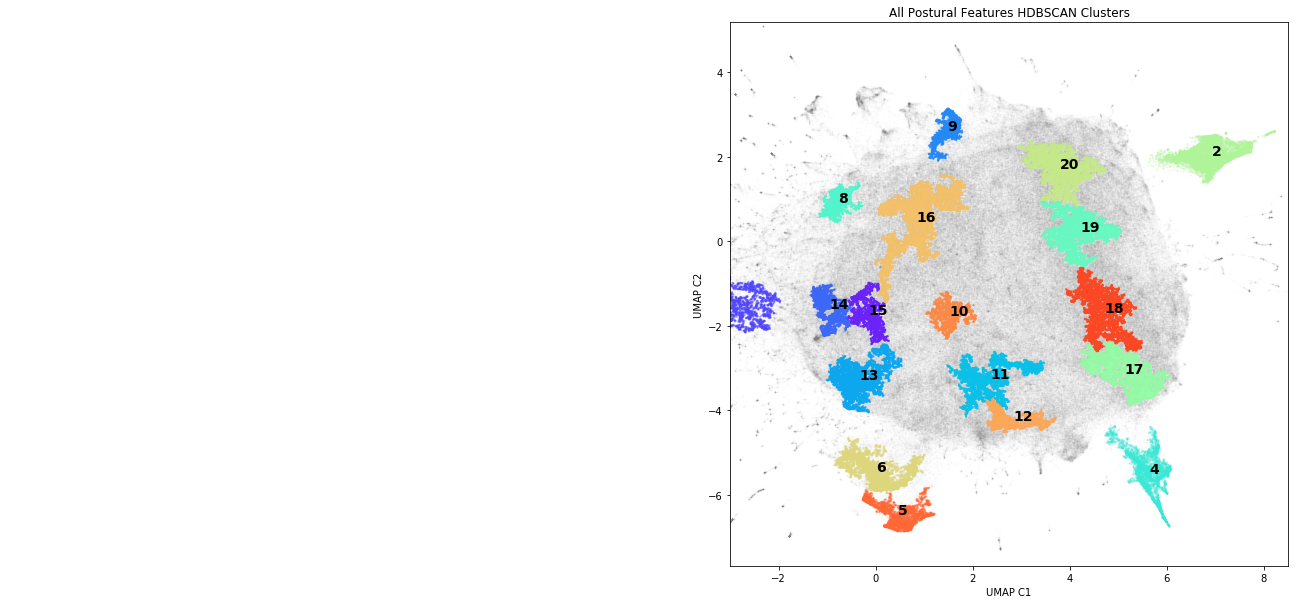

In [134]:
fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, xlim=region_x_lim, ylim=region_y_lim)
plt.show()

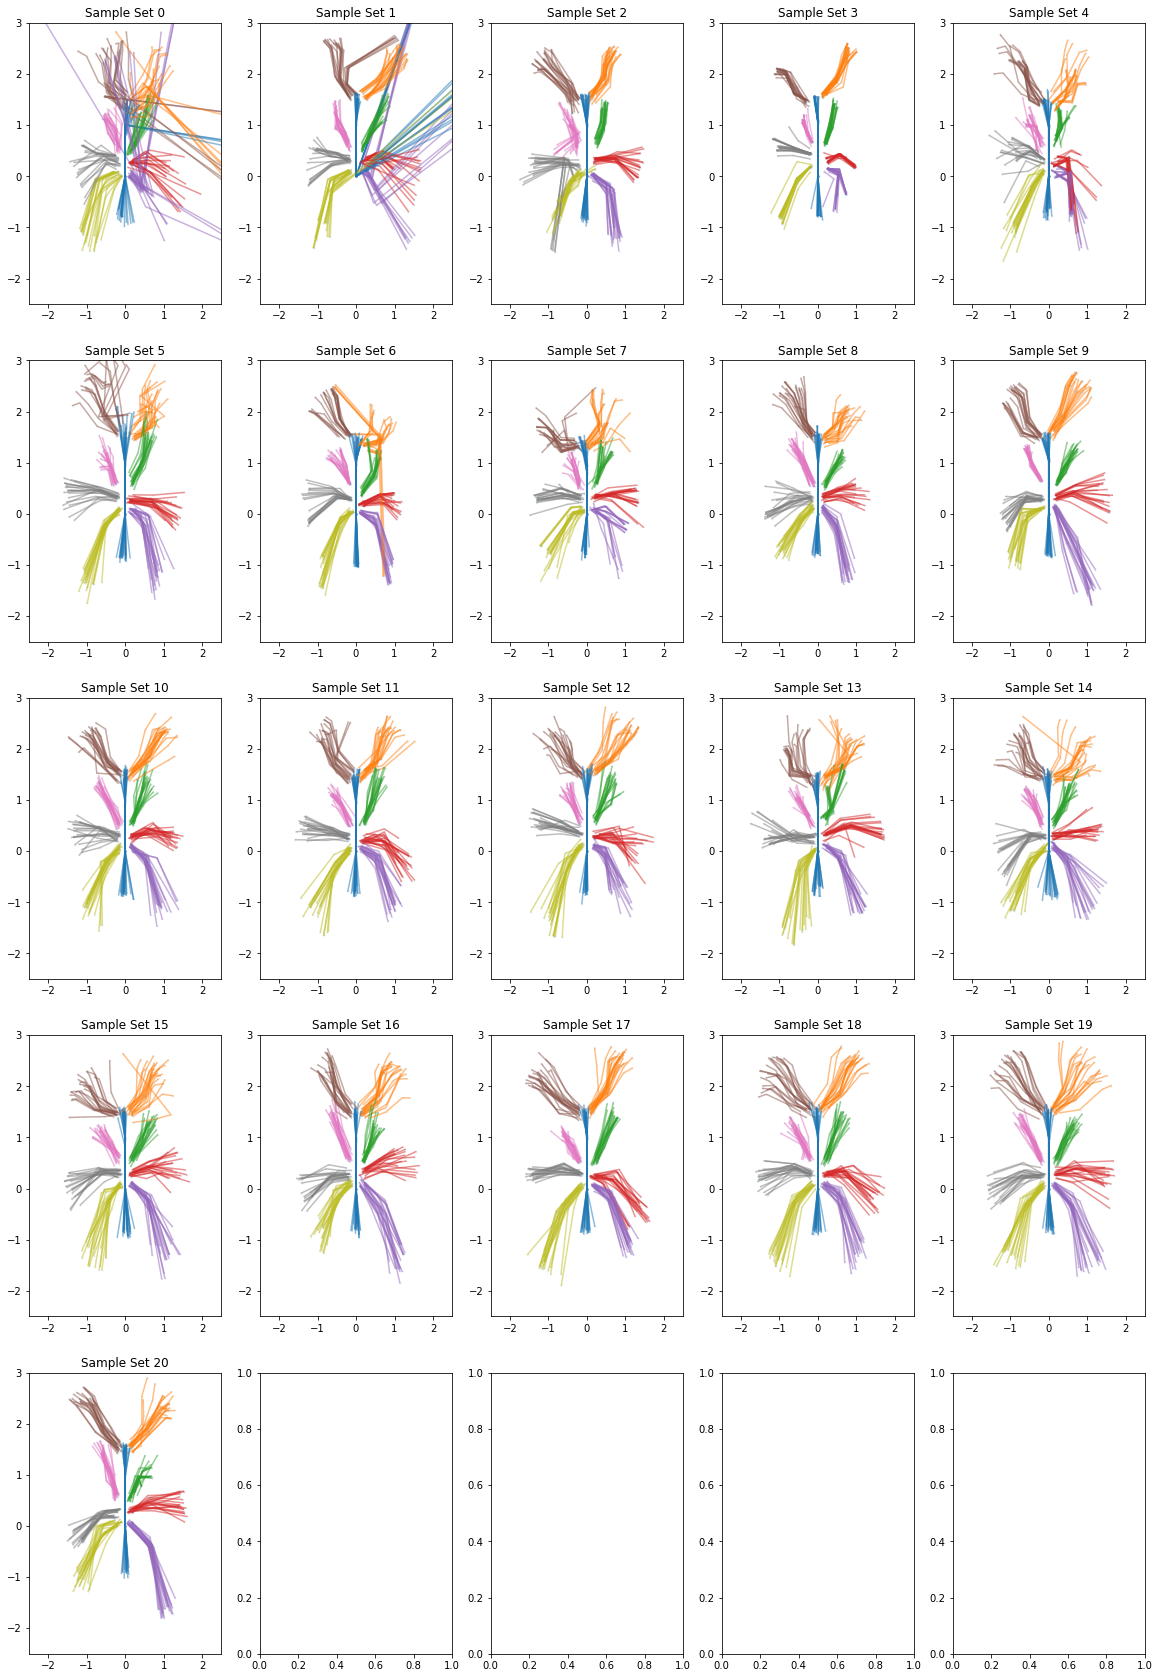

In [17]:
%matplotlib inline

num_fig_width, num_fig_height = 5,5
fig, ax = plt.subplots(num_fig_height, num_fig_width, figsize=(num_fig_width*4, num_fig_height*6))

for i in np.arange(num_clusters):
    fr_i = np.where(labels == i)[0]
    fr_i = fr_i[:20]
    ax[int(i//num_fig_width), int(i%num_fig_width)].scatter(bp[fr_i,:,0], bp[fr_i,:,1], s=2, alpha=0.05)
    ax[int(i//num_fig_width), int(i%num_fig_width)].set(title= f"Sample Set {int(i)}", xlim=(-2.5,2.5), ylim=(-2.5,3.0))
    
    # build skeleton
    for fr in fr_i:
        for skeleton_i, color_i in zip(skeleton, skeleton_color):
            ax[int(i//num_fig_width), int(i%num_fig_width)].plot(bp[fr,skeleton_i,0], bp[fr,skeleton_i,1], alpha=0.5, c=color_i)
plt.show()

<center><h1>Marker Embedding</h1></center>

[(-32.17791500176165, 22.386042977225515),
 Text(0, 0.5, 'UMAP C2'),
 (-23.762903780241896, 25.492680162688185),
 Text(0.5, 0, 'UMAP C1'),
 Text(0.5, 1.0, 'All Postural Features Embedding'),
 None]

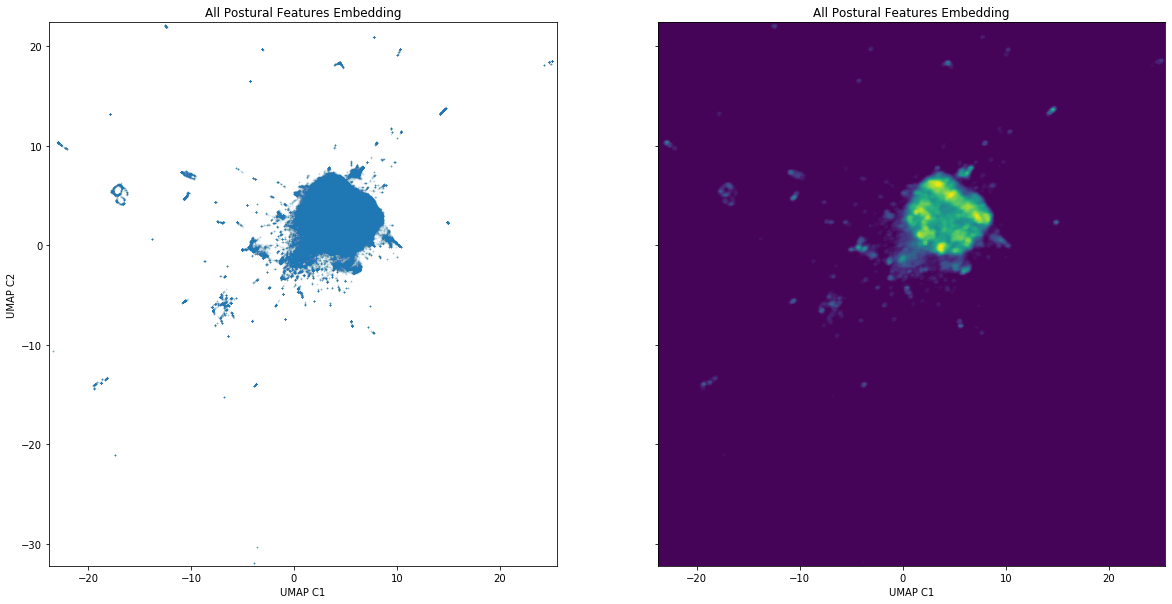

In [19]:
# %matplotlib qt 
# %matplotlib inline


idx = random.choices(np.arange(num_fr), k=int(num_fr*2/3))

# Scatter Plot
fig_marker_embed, ax_marker_embed = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

ax_marker_embed[0].scatter(marker_embed[idx,0], marker_embed[idx,1], s=1, alpha=0.015)
ax_marker_embed[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding")

# Density Plot
sns.kdeplot(x=marker_embed[idx,0], y=marker_embed[idx,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.3,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_marker_embed[1])
ax_marker_embed[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                    xlim=ax_marker_embed[0].get_xlim() ,ylim=ax_marker_embed[0].get_ylim())


<center><h1>Angle Embedding</h1></center>

[(-11.946219851139642, 22.58046286261425),
 Text(0, 0.5, 'UMAP C2'),
 (-13.64783935212747, 22.891273304459013),
 Text(0.5, 0, 'UMAP C1'),
 Text(0.5, 1.0, 'All Postural Features Embedding'),
 None]

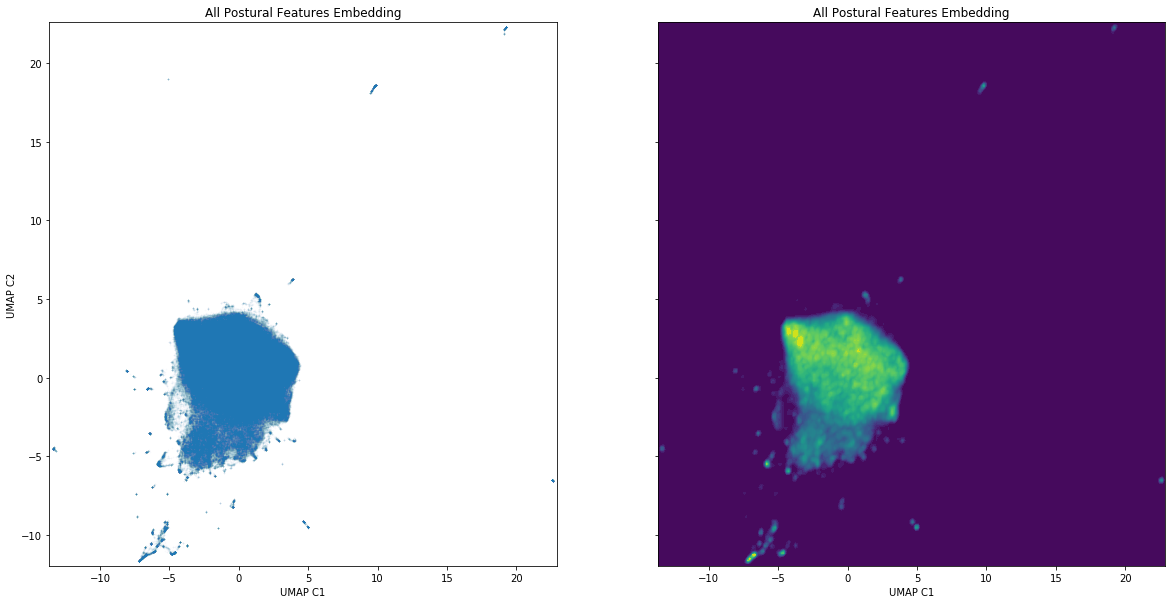

In [20]:

idx = random.choices(np.arange(num_fr), k=int(num_fr*2/3))

# Scatter Plot
fig_angle_embed, ax_angle_embed = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

ax_angle_embed[0].scatter(angle_embed[idx,0], angle_embed[idx,1], s=1, alpha=0.015)
ax_angle_embed[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding")

# Density Plot
sns.kdeplot(x=angle_embed[idx,0], y=angle_embed[idx,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.3,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_angle_embed[1])
ax_angle_embed[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                    xlim=ax_angle_embed[0].get_xlim() ,ylim=ax_angle_embed[0].get_ylim())

<center><h1>Limb Embedding</h1></center>

[(-30.0271371336614, 33.77525076586355),
 Text(0, 0.5, 'UMAP C2'),
 (-12.357610769264912, 22.050793714516377),
 Text(0.5, 0, 'UMAP C1'),
 Text(0.5, 1.0, 'All Postural Features Embedding'),
 None]

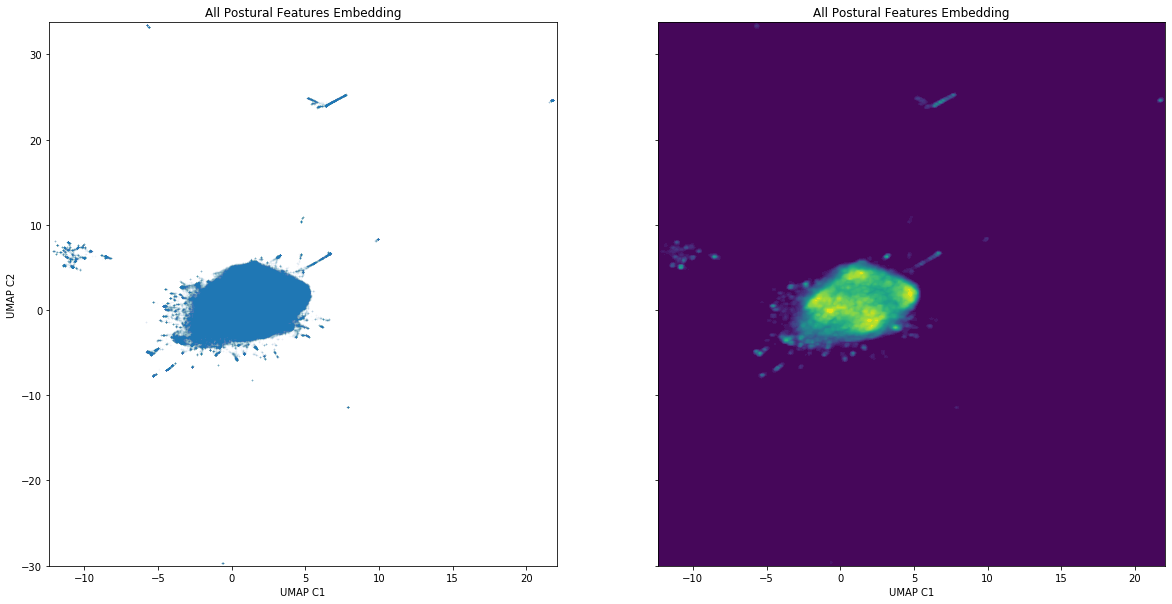

In [21]:

idx = random.choices(np.arange(num_fr), k=int(num_fr*2/3))

# Scatter Plot
fig_limb_embed, ax_limb_embed = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

ax_limb_embed[0].scatter(limb_embed[idx,0], limb_embed[idx,1], s=1, alpha=0.015)
ax_limb_embed[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding")

# Density Plot
sns.kdeplot(x=limb_embed[idx,0], y=limb_embed[idx,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.3,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_limb_embed[1])
ax_limb_embed[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                    xlim=ax_limb_embed[0].get_xlim() ,ylim=ax_limb_embed[0].get_ylim())